# 🧠 Laborator: Analiza Bias-ului și Corectitudinea Algoritmică

Acest laborator explorează modul în care bias-ul (părtinirea) afectează performanța și corectitudinea modelelor de învățare automată.
Vom simula, evalua și analiza efectele bias-ului, apoi vom explora metode de corectare și auditare a corectitudinii.

---

## 📘 Etapele proiectului

1. **Baseline (Referința):**
   Crearea unui set de date *perfect echilibrat* și antrenarea modelelor pe date „curate”.

2. **Simularea Bias-ului:**
   Eliminarea intenționată a datelor pentru un subgrup specific (ex: femeile care fac churn), pentru a simula pierderea istorică a datelor.

3. **Evaluare comparativă:**
   Vizualizarea degradării performanței prin metrici precum *Accuracy*, *Precision*, *Recall*, *F1* și *ROC-AUC*.

4. **Audit de corectitudine (Fairness Audit):**
   Utilizarea bibliotecii [`fairlearn`](https://fairlearn.org/) pentru a măsura disparitățile demografice și impactul asupra grupurilor sensibile.

---

> 🔍 **Scopul general:**
> Înțelegerea modului în care bias-ul poate distorsiona deciziile algoritmice și aplicarea metodelor de atenuare pentru a obține modele mai echitabile și mai robuste.


## ⚙️ Configurarea mediului și stilului grafic

În această secțiune sunt definite setările de bază pentru vizualizări și afișarea rezultatelor.
Se dezactivează avertismentele neesențiale și se configurează tema vizuală `seaborn` pentru o prezentare clară și coerentă.


In [1]:
import seaborn as sns
import warnings

# Dezactivarea avertismentelor neesențiale pentru claritate
warnings.filterwarnings('ignore')

# Setarea stilului grafic pentru vizualizări
sns.set(style="whitegrid", context="talk")

## 🧩 PARTEA 1 — Stabilirea Baseline-ului (Setul de Date Echilibrat)

Pentru a putea simula corect bias-ul, trebuie să pornim de la o situație „ideală”.
Setul de date original este dezechilibrat (aprox. 80% **Non-Churn** / 20% **Churn**), ceea ce poate afecta performanța modelului.
Prin urmare, vom crea un **subset echilibrat**, obținut prin *undersampling* al clasei majoritare. Acesta va reprezenta **adevărul obiectiv**, adică punctul de referință pentru toate comparațiile ulterioare.

---

Crearea unui set de date echilibrat ne permite să demonstrăm că eventualele degradări de performanță provin **strict din bias-ul introdus ulterior**,
nu din dezechilibrul natural al datelor inițiale.


In [2]:
import pandas as pd

# Încărcarea setului de date
df = pd.read_csv('data/Churn_Modelling.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [3]:
# Eliminarea coloanelor irelevante pentru analiză
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


In [4]:
from sklearn.preprocessing import LabelEncoder

# Codificarea variabilelor categoriale
le = LabelEncoder()
df['Gender'] = le.fit_transform(df['Gender'])  # 0 = Female, 1 = Male

# One-hot encoding pentru coloana 'Geography'
df = pd.get_dummies(df, columns=['Geography'], drop_first=True)

# Verificare rezultat
df[['Gender', 'Geography_Germany', 'Geography_Spain']].head()

,Gender,Geography_Germany,Geography_Spain
0,0,False,False
1,0,False,True
2,0,False,False
3,0,False,False
4,0,False,True


In [5]:
# Crearea setului de date echilibrat (Baseline)
shuffled_df = df.sample(frac=1, random_state=42)

# Selectarea observațiilor pentru fiecare clasă
churn_df = shuffled_df[shuffled_df['Exited'] == 1]
non_churn_df = shuffled_df[shuffled_df['Exited'] == 0].sample(
    n=len(churn_df), random_state=42
)

# Combinarea într-un set echilibrat (50/50)
balanced_df = pd.concat([churn_df, non_churn_df])

# Verificarea distribuției claselor
print("Distribuția claselor în setul echilibrat:")
balanced_df['Exited'].value_counts()

Distribuția claselor în setul echilibrat:


Exited
1    2037
0    2037
Name: count, dtype: int64

In [6]:
from sklearn.model_selection import train_test_split

# Împărțirea setului de date în train și test
X = balanced_df.drop('Exited', axis=1)
y = balanced_df['Exited']

# Salvăm separat coloana sensibilă (Gender) pentru auditul de fairness ulterior
sensitive_feature = balanced_df['Gender']

# Păstrăm 30% din date pentru testare
X_train_clean, X_test, y_train_clean, y_test, gender_train, gender_test = train_test_split(
    X, y, sensitive_feature,
    test_size=0.3,
    random_state=42,
    stratify=y
)

In [7]:
from sklearn.preprocessing import StandardScaler

# Scalare
scaler = StandardScaler()
X_train_clean_sc = scaler.fit_transform(X_train_clean)
X_test_sc = scaler.transform(X_test)

## 🧪 Antrenarea modelelor pe date curate (Baseline)

În această etapă vom antrena trei modele din familia regresiilor, pentru a stabili performanța de referință (*Bias = 0%*).
Aceste rezultate vor constitui linia de start pentru comparațiile ulterioare, după introducerea bias-ului controlat.

---

### Modelele utilizate
1. **Logistic Regression** — model liniar clasic pentru clasificare binară.
2. **SGD Classifier** — model liniar optimizat stocastic, potrivit pentru date mari.
3. **Deep Learning MLP** — rețea neuronală simplă (Multi-Layer Perceptron).

---

In [8]:
from sklearn.linear_model import SGDClassifier, LogisticRegression
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential

# Definirea celor trei modele de bază (Baseline)
def get_models():
    # Logistic Regression
    lr = LogisticRegression(random_state=42)

    # Stochastic Gradient Descent (cu log_loss pentru probabilități)
    sgd = SGDClassifier(
        loss='log_loss',
        random_state=42,
        max_iter=2000
    )

    # Rețea neuronală simplă (MLP)
    dl = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_clean.shape[1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    dl.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return lr, sgd, dl


# Inițializare modele baseline
lr_base, sgd_base, dl_base = get_models()

# Antrenarea modelelor pe setul echilibrat (curat)
lr_base.fit(X_train_clean_sc, y_train_clean)
sgd_base.fit(X_train_clean_sc, y_train_clean)
dl_base.fit(X_train_clean_sc, y_train_clean, epochs=30, batch_size=16, verbose=0)



## ⚖️ PARTEA 2 — Simularea Bias-ului Controlat

**Scenariu:**
Simulăm o eroare în colectarea datelor sau un bias istoric, pentru a observa impactul asupra performanței modelelor.

**Mecanism:**
Vom elimina progresiv (20%, 40%, 60%, 80%) din datele care îndeplinesc următoarele condiții:

- **Feature:** `Gender = Female (0)`
- **Target:** `Exited = 1` *(Churn)*

Aceasta reprezintă o formă de **Bias Intersecțional**,
în care modelul „uită” cum arată un anumit subgrup (femeile care părăsesc banca).

Ulterior, modelele biasate vor fi testate pe **setul de test original** (care include și aceste cazuri) pentru a măsura degradarea performanței.

In [9]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
)
import numpy as np

# Nivelurile de bias care vor fi simulate
bias_levels = [0.2, 0.4, 0.6, 0.8]
results_data = []

# Modelele de referință (Bias = 0%)
models_base = [
    ('Logistic Reg', lr_base),
    ('SGD', sgd_base),
    ('Deep Learning', dl_base)
]


In [10]:
# Adăugarea rezultatelor pentru Baseline (Bias 0%)
for name, model in models_base:
    if name == 'Deep Learning':
        probs = model.predict(X_test_sc, verbose=0).ravel()
        preds = (probs > 0.5).astype(int)
    else:
        probs = model.predict_proba(X_test_sc)[:, 1]
        preds = model.predict(X_test_sc)

    results_data.append({
        'Bias Level': '0%',
        'Model': name,
        'Accuracy': accuracy_score(y_test, preds),
        'Recall': recall_score(y_test, preds),
        'Precision': precision_score(y_test, preds),
        'F1 Score': f1_score(y_test, preds),
        'AUC': roc_auc_score(y_test, probs)
    })


In [11]:
# --- Simularea Bias-ului Controlat ---
for bias in bias_levels:
    print(f"Simulare pentru Bias Level: {bias*100}%...")

    # 1️⃣ Identificarea rândurilor Female & Churn=1 pentru eliminare
    train_temp = X_train_clean.copy()
    train_temp['Exited'] = y_train_clean
    target_mask = (train_temp['Gender'] == 0) & (train_temp['Exited'] == 1)
    target_indices = train_temp[target_mask].index

    n_remove = int(len(target_indices) * bias)
    np.random.seed(42)
    drop_indices = np.random.choice(target_indices, n_remove, replace=False)

    # 2️⃣ Crearea setului biasat
    X_train_biased = train_temp.drop(drop_indices).drop('Exited', axis=1)
    y_train_biased = train_temp.drop(drop_indices)['Exited']

    # 3️⃣ Rescalarea
    scaler_bias = StandardScaler()
    X_tr_bias_sc = scaler_bias.fit_transform(X_train_biased)
    X_te_bias_sc = scaler_bias.transform(X_test)

    # 4️⃣ Reantrenarea modelelor
    lr_b, sgd_b, dl_b = get_models()

        # Logistic Regression
    lr_b.fit(X_tr_bias_sc, y_train_biased)
    probs_lr = lr_b.predict_proba(X_te_bias_sc)[:, 1]
    preds_lr = lr_b.predict(X_te_bias_sc)

    # SGD Classifier
    sgd_b.fit(X_tr_bias_sc, y_train_biased)
    probs_sgd = sgd_b.predict_proba(X_te_bias_sc)[:, 1]
    preds_sgd = sgd_b.predict(X_te_bias_sc)

    # Deep Learning (MLP)
    dl_b.fit(X_tr_bias_sc, y_train_biased, epochs=30, batch_size=16, verbose=0)
    probs_dl = dl_b.predict(X_te_bias_sc, verbose=0).ravel()
    preds_dl = (probs_dl > 0.5).astype(int)

    # Colectarea metricilor
    for name, preds, probs in [
        ('Logistic Reg', preds_lr, probs_lr),
        ('SGD', preds_sgd, probs_sgd),
        ('Deep Learning', preds_dl, probs_dl)
    ]:
        results_data.append({
            'Bias Level': f"{int(bias * 100)}%",
            'Model': name,
            'Accuracy': accuracy_score(y_test, preds),
            'Recall': recall_score(y_test, preds),
            'Precision': precision_score(y_test, preds),
            'F1 Score': f1_score(y_test, preds),
            'AUC': roc_auc_score(y_test, probs)
        })


Simulare pentru Bias Level: 20.0%...
Simulare pentru Bias Level: 40.0%...
Simulare pentru Bias Level: 60.0%...
Simulare pentru Bias Level: 80.0%...


In [12]:
# Rezultatele finale
df_res = pd.DataFrame(results_data)
df_res

,Bias Level,Model,Accuracy,Recall,Precision,F1 Score,AUC
0,0%,Logistic Reg,0.714636,0.693944,0.723549,0.708438,0.772392
1,0%,SGD,0.692559,0.700491,0.689211,0.694805,0.740290
2,0%,Deep Learning,0.760425,0.741408,0.770408,0.755630,0.847590
3,20%,Logistic Reg,0.705642,0.643208,0.734579,0.685864,0.770581
4,20%,SGD,0.659853,0.522095,0.720090,0.605313,0.727603
5,20%,Deep Learning,0.755519,0.715221,0.777580,0.745098,0.844581
6,40%,Logistic Reg,0.694195,0.589198,0.745342,0.658135,0.763002
7,40%,SGD,0.674571,0.743044,0.653237,0.695253,0.743477
8,40%,Deep Learning,0.755519,0.675941,0.803502,0.734222,0.845881
9,60%,Logistic Reg,0.678659,0.513912,0.765854,0.615083,0.746398


## PARTEA 3: Vizualizarea și Interpretarea Rezultatelor

Urmărim cum **scad** metricile pe măsură ce creștem bias-ul (de la 0% la 80%).
Focus principal: **Recall** (Capacitatea de a găsi clienții care pleacă) și **AUC**.

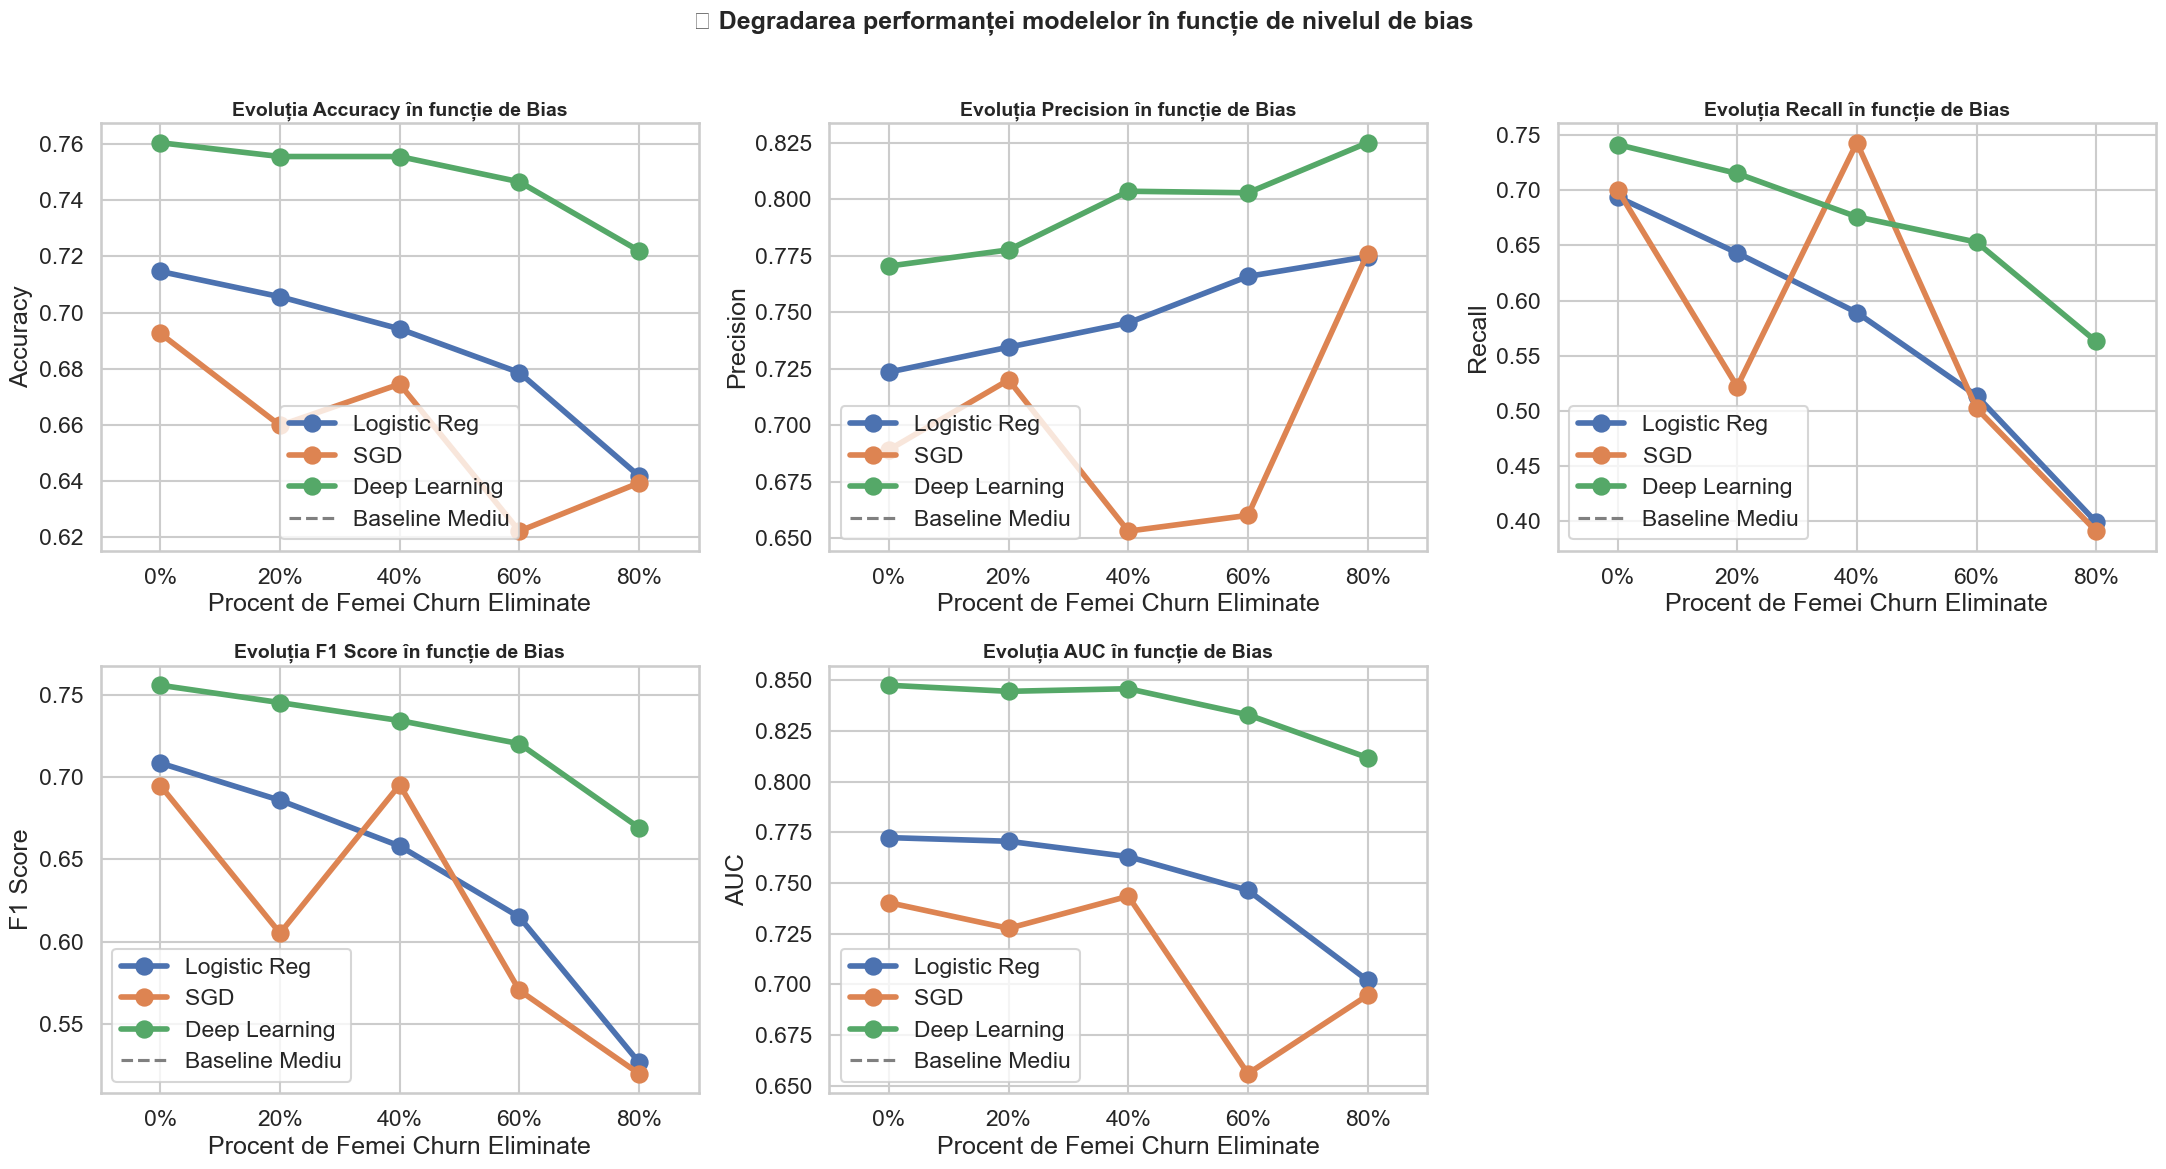

In [13]:
import matplotlib.pyplot as plt

# 1️⃣ Configurare grafică generală
sns.set_theme(style="whitegrid", context="talk", palette="deep")

metrics_plot = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']
fig, axes = plt.subplots(2, 3, figsize=(22, 12))
axes = axes.flatten()

# 2️⃣ Vizualizarea degradării fiecărei metrici în funcție de nivelul de bias
for i, metric in enumerate(metrics_plot):
    sns.pointplot(
        data=df_res,
        x='Bias Level',
        y=metric,
        hue='Model',
        ax=axes[i],
        capsize=.1
    )

    axes[i].set_title(f'Evoluția {metric} în funcție de Bias', fontsize=14, fontweight='bold')
    axes[i].set_xlabel('Procent de Femei Churn Eliminate')
    axes[i].set_ylabel(metric)
    axes[i].axhline(
        y=df_res[df_res['Bias Level'] == '0% (Baseline)'][metric].mean(),
        color='gray',
        linestyle='--',
        label='Baseline Mediu'
    )
    axes[i].grid(True)
    axes[i].legend()

# 3️⃣ Eliminăm subplotul gol (deoarece sunt 5 metrici, nu 6)
fig.delaxes(axes[-1])

plt.suptitle('📉 Degradarea performanței modelelor în funcție de nivelul de bias', fontsize=18, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

## ⚖️ PARTEA 4 — Fairness Audit cu Fairlearn

În această etapă vom folosi biblioteca **Fairlearn** pentru a „deschide cutia neagră” a celui mai biasat model (nivel **80%**) și pentru a analiza **pe cine discriminează** modelul.

Vom compara:
- 🔹 **Modelul Baseline (corect)**
- 🔹 **Modelul Biasat (incorect, bias = 80%)**

---

### 🔍 Metrici analizate

1. **Selection Rate** — cât de des prezice modelul „Churn” (`Exited=1`) pentru bărbați vs femei.
2. **True Positive Rate (Recall)** — dintre clienții care chiar părăsesc banca, câți sunt corect identificați pentru fiecare gen.

Aceste valori ne vor permite să cuantificăm *disparitățile demografice* și să înțelegem dacă modelul tratează diferit subgrupurile sensibile.


In [14]:
from fairlearn.metrics import (
    MetricFrame,
    selection_rate,
    true_positive_rate,
    false_positive_rate
)

# 1️⃣ Predicții pe setul de test pentru ambele modele
y_pred_base = (dl_base.predict(X_test_sc, verbose=0).ravel() > 0.5).astype(int)
y_pred_biased = (dl_b.predict(X_test_sc, verbose=0).ravel() > 0.5).astype(int)  # Ultimul model din buclă (80% bias)

# 2️⃣ Mapare gen pentru lizibilitate
gender_test_labels = gender_test.map({0: 'Female', 1: 'Male'})

# 3️⃣ Analiza Fairness pentru Modelul de Bază (Corect)
metric_frame_base = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "recall (TPR)": true_positive_rate,
        "false_positive_rate": false_positive_rate,
        "selection_rate": selection_rate,
    },
    y_true=y_test,
    y_pred=y_pred_base,
    sensitive_features=gender_test_labels
)

# 4️⃣ Analiza Fairness pentru Modelul Biasat (80%)
metric_frame_biased = MetricFrame(
    metrics={
        "accuracy": accuracy_score,
        "recall (TPR)": true_positive_rate,
        "false_positive_rate": false_positive_rate,
        "selection_rate": selection_rate,
    },
    y_true=y_test,
    y_pred=y_pred_biased,
    sensitive_features=gender_test_labels
)

# 5️⃣ Afișare rezultate pentru modelul corect
print("--- ⚖️ FAIRNESS REPORT: BASELINE MODEL ---")
metric_frame_base.by_group

--- ⚖️ FAIRNESS REPORT: BASELINE MODEL ---


,accuracy,recall (TPR),false_positive_rate,selection_rate
Gender,,,,
Female,0.730706,0.747801,0.291045,0.546798
Male,0.789902,0.733333,0.165698,0.415309


In [15]:
# 6️⃣ Afișare rezultate pentru modelul biasat (nivel 80% bias)
print("\n--- ⚖️ FAIRNESS REPORT: BIASED MODEL (80% Missing Female Data) ---")
metric_frame_biased.by_group


--- ⚖️ FAIRNESS REPORT: BIASED MODEL (80% Missing Female Data) ---


,accuracy,recall (TPR),false_positive_rate,selection_rate
Gender,,,,
Female,0.650246,0.407625,0.041045,0.246305
Male,0.780130,0.681481,0.142442,0.379479


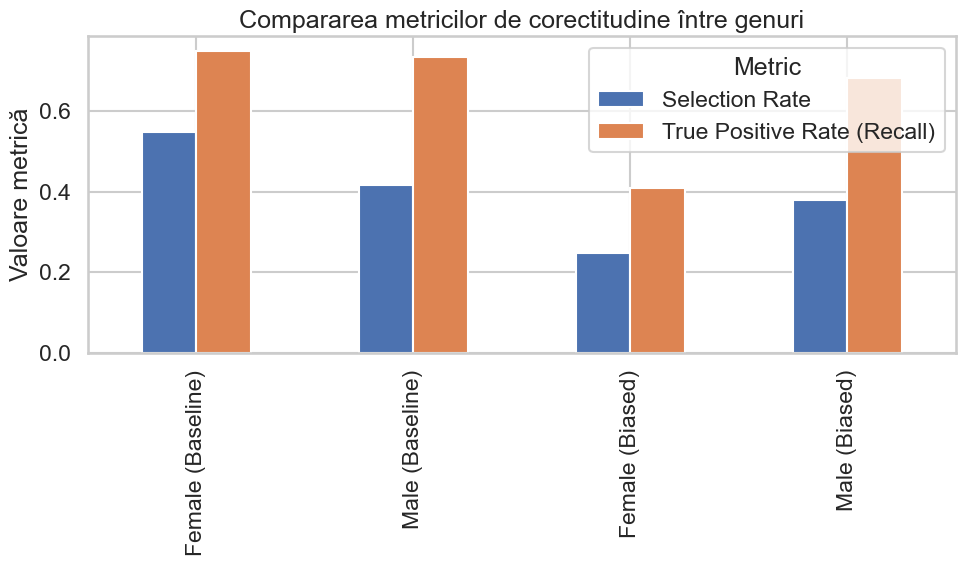

In [16]:
# 🔍 Vizualizare comparativă a fairness-ului pe gen
fairness_df = pd.DataFrame({
    'Metric': ['Selection Rate', 'True Positive Rate (Recall)'],
    'Female (Baseline)': [
        metric_frame_base.by_group.loc['Female', 'selection_rate'],
        metric_frame_base.by_group.loc['Female', 'recall (TPR)']
    ],
    'Male (Baseline)': [
        metric_frame_base.by_group.loc['Male', 'selection_rate'],
        metric_frame_base.by_group.loc['Male', 'recall (TPR)']
    ],
    'Female (Biased)': [
        metric_frame_biased.by_group.loc['Female', 'selection_rate'],
        metric_frame_biased.by_group.loc['Female', 'recall (TPR)']
    ],
    'Male (Biased)': [
        metric_frame_biased.by_group.loc['Male', 'selection_rate'],
        metric_frame_biased.by_group.loc['Male', 'recall (TPR)']
    ]
})

fairness_df.set_index('Metric').T.plot(kind='bar', figsize=(10,6))
plt.title('Compararea metricilor de corectitudine între genuri')
plt.ylabel('Valoare metrică')
plt.grid(True)
plt.tight_layout()
plt.show()

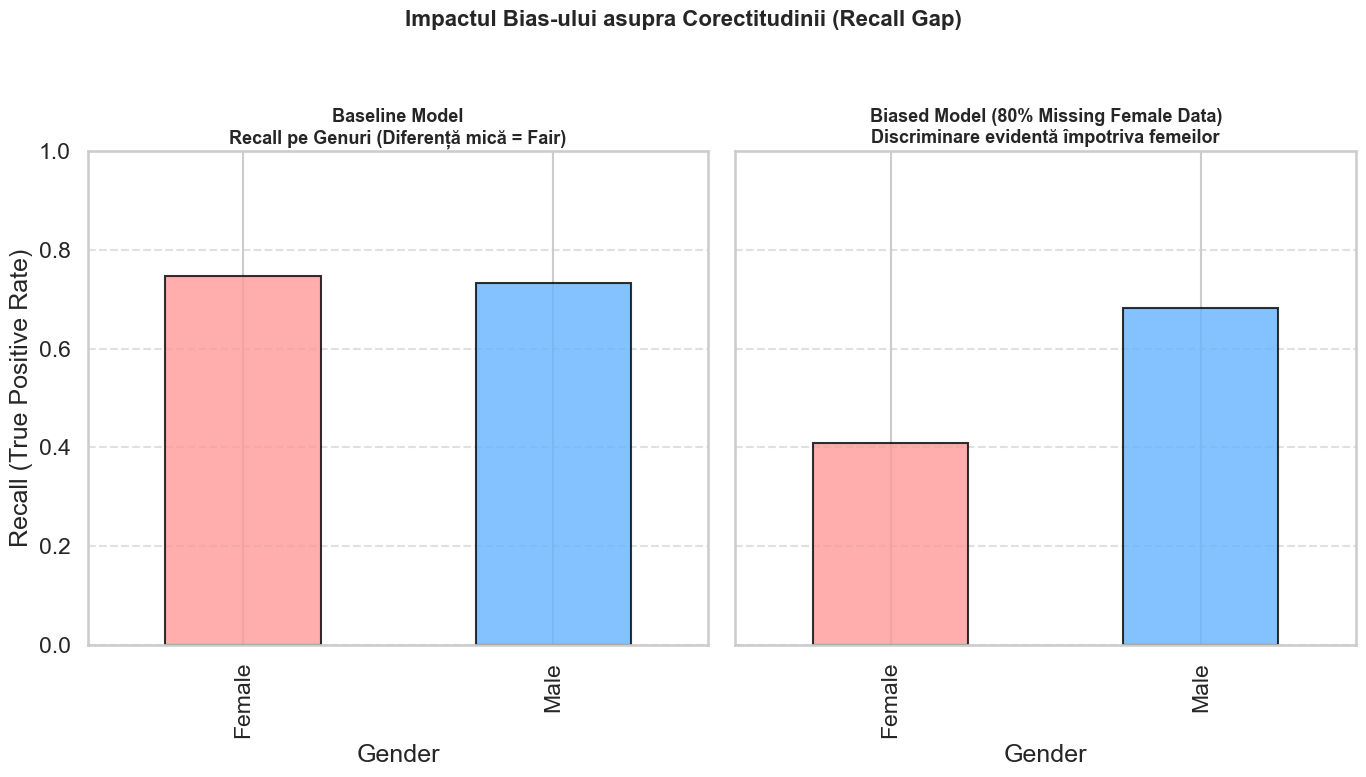

In [17]:
# 🔍 Vizualizarea diferenței de Recall între Femei și Bărbați
metrics_base = metric_frame_base.by_group['recall (TPR)']
metrics_bias = metric_frame_biased.by_group['recall (TPR)']

fig, ax = plt.subplots(1, 2, figsize=(14, 8), sharey=True)

# Model corect (Baseline)
metrics_base.plot(
    kind='bar',
    ax=ax[0],
    color=['#ff9999', '#66b3ff'],
    alpha=0.8,
    edgecolor='black'
)
ax[0].set_title('Baseline Model\nRecall pe Genuri (Diferență mică = Fair)', fontsize=13, fontweight='bold')
ax[0].set_ylabel('Recall (True Positive Rate)')
ax[0].set_ylim(0, 1)
ax[0].grid(axis='y', linestyle='--', alpha=0.6)

# Model biasat (80% Female Missing)
metrics_bias.plot(
    kind='bar',
    ax=ax[1],
    color=['#ff9999', '#66b3ff'],
    alpha=0.8,
    edgecolor='black'
)
ax[1].set_title('Biased Model (80% Missing Female Data)\nDiscriminare evidentă împotriva femeilor', fontsize=13, fontweight='bold')
ax[1].set_ylim(0, 1)
ax[1].grid(axis='y', linestyle='--', alpha=0.6)

# Titlu general
plt.suptitle('Impactul Bias-ului asupra Corectitudinii (Recall Gap)', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


## 🏁 Concluzii Finale

1. **Baseline-ul** a demonstrat o performanță echilibrată între genuri, fără diferențe semnificative între bărbați și femei.
2. **Simularea bias-ului controlat** — prin eliminarea datelor istorice despre femeile care părăsesc banca — a afectat sever capacitatea modelului de a recunoaște acest grup, ducând la o degradare clară a performanței.
3. **Auditul de corectitudine (Fairness Audit)** a confirmat discriminarea algoritmică: în modelul biasat, *Recall*-ul pentru femei este semnificativ mai mic decât pentru bărbați (*Disparate Impact*), deși setul de test conține grupuri cu comportamente similare.

---

> 💡 **Concluzie generală:**
> Bias-ul în datele de antrenament se propagă direct în deciziile modelului.
> Corectitudinea algoritmică nu este un efect secundar al performanței, ci o componentă esențială pentru modelele care iau decizii cu impact asupra oamenilor.
